FMA 데이터를 사용해 지정된 장르를 XGBoost Classifier을 이용해 예측하는 간단한 실험이다. 피쳐(feature)로 스펙트럼 피쳐, 크로마그램 피쳐, MFCC, 제로-크로싱 레이트 등을 사용한다.

In [35]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, \
ConfusionMatrixDisplay, classification_report

from sklearn.model_selection import train_test_split
import IPython.display as ipd

# 데이터

미리 생성된 데이터를 불러온다. 

데이터는 [FMA](https://github.com/mdeff/fma)의 106574곡 중 장르가 지정되지 않은 곡을 제외하여 104343곡을 사용한다. 장르를 label로 하며 feature는 518개이다.

In [61]:
# 데이터 불러오기

data = pd.read_csv('data/data_FMA_genre_clf.csv', index_col=0)

In [62]:
data.columns

Index(['genre_top', 'chroma_cens_01_kurtosis', 'chroma_cens_02_kurtosis',
       'chroma_cens_03_kurtosis', 'chroma_cens_04_kurtosis',
       'chroma_cens_05_kurtosis', 'chroma_cens_06_kurtosis',
       'chroma_cens_07_kurtosis', 'chroma_cens_08_kurtosis',
       'chroma_cens_09_kurtosis',
       ...
       'tonnetz_04_std', 'tonnetz_05_std', 'tonnetz_06_std', 'zcr_01_kurtosis',
       'zcr_01_max', 'zcr_01_mean', 'zcr_01_median', 'zcr_01_min',
       'zcr_01_skew', 'zcr_01_std'],
      dtype='object', length=519)

In [63]:
data

,genre_top,chroma_cens_01_kurtosis,chroma_cens_02_kurtosis,chroma_cens_03_kurtosis,chroma_cens_04_kurtosis,chroma_cens_05_kurtosis,chroma_cens_06_kurtosis,chroma_cens_07_kurtosis,chroma_cens_08_kurtosis,chroma_cens_09_kurtosis,...,tonnetz_04_std,tonnetz_05_std,tonnetz_06_std,zcr_01_kurtosis,zcr_01_max,zcr_01_mean,zcr_01_median,zcr_01_min,zcr_01_skew,zcr_01_std
2,Hip-Hop,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,Hip-Hop,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,Hip-Hop,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,Pop,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,Pop,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,Rock,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
155317,Rock,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
155318,Rock,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
155319,Rock,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


In [64]:
print(data.genre_top.unique(), '\n', '장르 수: ', len(data.genre_top.unique()))

['Hip-Hop' 'Pop' 'Rock' 'Experimental' 'Folk' 'Jazz' 'Electronic' 'Blues'
 'Spoken' 'International' 'Soul-RnB' 'Classical' 'Country'
 'Easy Listening' 'Old-Time / Historic' 'Instrumental'] 
 장르 수:  16


# 레이블(Label)

## 장르 모호성과 레이블 불균형

In [65]:
top_genres = data.genre_top.value_counts()
top_genres

Electronic             25046
Experimental           22724
Rock                   21282
Pop                     8015
Folk                    6083
Hip-Hop                 4534
Instrumental            4367
International           2924
Jazz                    2293
Classical               2102
Blues                   1676
Soul-RnB                 920
Spoken                   768
Country                  726
Old-Time / Historic      710
Easy Listening           173
Name: genre_top, dtype: int64

본 실험의 목적은 음악적 장르를 오디오 feature로 잘 분류할 수 있는가이다. 이 때 장르는 사람이 지정한 라벨이기 때문에 음악적 특성 외에도 사회문화적, 아티스트의 배경, 역사적 요소 등이 고려될 수 있다. 위의 장르를 보면, "International"같은 장르는 특히나 음악적 특성을 반영하기 보다는 영미권 음악 시장 위주의 배경으로부터 분류된 장르이기 때문에 이 실험의 레이블로서 특징이 모호하다. 따라서 그러한 장르를 임의로 제외하기로 한다. (instrumental, international, easy-listening)

또한 실험을 나이브하지만 조금 더 간단히 하기 위해 레이블 불균형을 완화할 목적으로 레이블 수가 1000개 미만인 장르 또한 제외하기로 한다.

In [66]:
international_ids = data[data['genre_top']=='International'].index
instrumental_ids = data[data['genre_top']=='Instrumental'].index
data = data.drop(index=international_ids)
data = data.drop(index=instrumental_ids)

In [67]:
small_genres = top_genres[top_genres<1000].index
for x in small_genres:
    ids = data[data['genre_top']==x].index
    data = data.drop(index=ids)

In [68]:
len(data)

93755

이제 93755개의 노래가 남는다. 실험하기에 그리 작은 양은 아니다.

# 데이터 스플릿

훈련, 테스트 데이터로 나눈다. 7:3 비율로 하며 무작위로 뽑는다.

In [69]:
raw_X = data.drop(columns=['genre_top'])

labels = data.loc[:,'genre_top']
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

# train / test
raw_X_train, raw_X_test, y_train, y_test = train_test_split(raw_X, y, test_size=0.3, shuffle=True, random_state=123)

In [70]:
print(len(y_train), len(y_test))

65628 28127


# 피쳐 (feature)

데이터의 feature는 총 518개이다.

각 feature는 time-domain의 시리즈로 형성되기 때문에 통계값을 구해 feature로 쓴다. mean, median, standard deviation, skewness, kurtosis, maximum, minium 총 7개씩 구한다.

- 크로마그램: (크로마 피치 12개 x 방식 3개) + 토네츠 피치 6개
    - chroma cens 1~12
    - chroma cqt 1~12
    - chroma stft 1~12
    - tonnetz 1~6
- MFCC 1~20 (20개)
- RMSE (root mean square of energy) (1개)
- ZCR (zero crossing rate) (1개)
- 스펙트로그램 (10개)
    - bandwidth
    - centroid
    - rolloff
    - Contrast Subbands 1~7 
    
총 74개의 feature x 7개 통계값: 518개

이들 중 상관관계가 매우 높은 feature들이 있다. 크로마그램의 경우 STFT, CQT, CENS는 방식이 다를뿐 포함하는 정보의 의미 (피치클래스 크기)는 같다. 또한 스펙트로그램 feature의 bandwidth, centroid, rolloff 등도 비슷하다.

따라서 PCA를 이용한 차원축소를 통해 선형적 상관관계가 있는 feature의 개수를 줄여준다.

## 차원 축소 - PCA

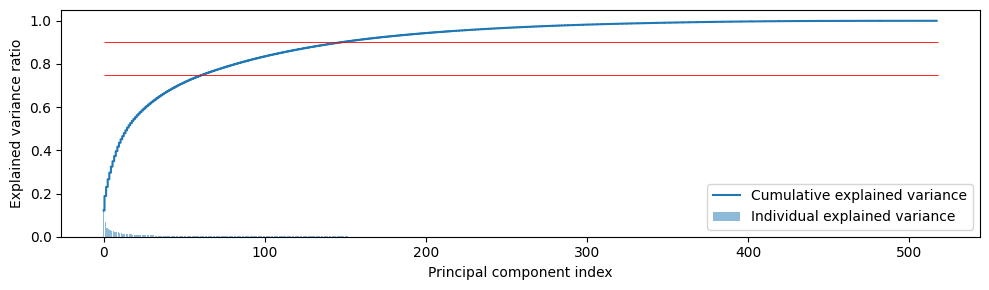

In [71]:
sc = StandardScaler()
raw_X_scaled_train = sc.fit_transform(raw_X_train)
raw_X_scaled_test = sc.transform(raw_X_test)

pca = PCA()
ft_pca = pca.fit_transform(raw_X_scaled_train)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(10,3))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.75, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

전체 feature의 explained variance를 0.75, 즉 분산의 75%를 설명할 수 있는 PC 개수를 정하기로 한다. 정확히 자르기보다는 대충 50개라고 하자.

Standard Scaler와 PCA fitting 모두 훈련데이터에서만 한 후, 테스트데이터에 대해서는 변형(transform)만 한다.

In [72]:
n_comps = 50 # 0.75 explained variance for pca
pca = PCA(n_components=n_comps)
X_train = pca.fit_transform(raw_X_scaled_train)
X_train = pd.DataFrame(X_train, index=raw_X_train.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
X_test = pca.transform(raw_X_scaled_test)
X_test = pd.DataFrame(X_test, index=raw_X_test.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
components = pca.components_.T

# 모형 (Model)

## XGBoost

In [73]:
xgb = XGBClassifier(n_estimators=50)

In [74]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [75]:
y_true = y_test.copy()
y_pred = xgb.predict(X_test)

In [76]:
print('XGB Accuracy: ', accuracy_score(y_true, y_pred))
print('XGB F1: ', f1_score(y_true, y_pred, average='macro'))

XGB Accuracy:  0.5297045543428023
XGB F1:  0.41522942538146473


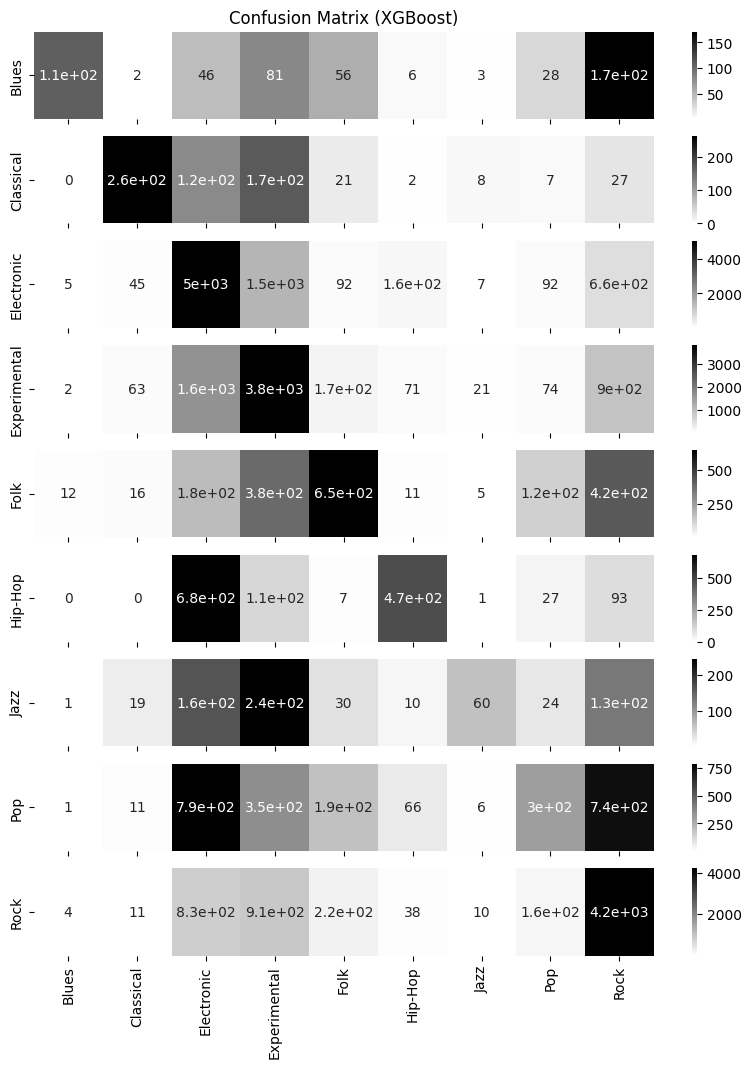

In [80]:
fig, axs = plt.subplots(9, figsize=(10,12), sharex=True)
axs[0].set_title('Confusion Matrix (XGBoost)')
axs[8].set_xlabel('Predicted labels')

for i in range(9):    
    sns.heatmap(confusion_matrix(y_true, y_pred)[i].reshape(1,-1), annot=True, cmap='gray_r',
                xticklabels=cat_y.categories, yticklabels=[cat_y.categories[i]], ax=axs[i])
plt.show()

In [81]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))
print(dict(zip(cat_y.categories, range(10))))

XGB classification report: 

              precision    recall  f1-score   support

           0       0.81      0.22      0.34       501
           1       0.61      0.43      0.50       616
           2       0.53      0.67      0.59      7568
           3       0.51      0.56      0.53      6729
           4       0.45      0.36      0.40      1794
           5       0.56      0.34      0.42      1392
           6       0.50      0.09      0.15       682
           7       0.36      0.12      0.18      2458
           8       0.57      0.66      0.61      6387

    accuracy                           0.53     28127
   macro avg       0.54      0.38      0.42     28127
weighted avg       0.52      0.53      0.51     28127

{'Blues': 0, 'Classical': 1, 'Electronic': 2, 'Experimental': 3, 'Folk': 4, 'Hip-Hop': 5, 'Jazz': 6, 'Pop': 7, 'Rock': 8}


각 장르별 f1-score를 확인해보면, 클래식, 일렉트로닉, 익스페리멘털, 록 음악은 점수가 높고, 재즈와 팝 음악이 점수가 낮다.

어떤 장르가 오분류되었는지 자세히 살펴보자. 다음은 잘못 분류한 장르 쌍 중 가장 많은 것이다.

- 블루스를 록으로 오분류

- 힙합을 일렉트로닉으로 오분류

- 재즈를 익스페리멘털로 오분류

- 팝을 일렉트로닉으로 오분류

- 팝을 록으로 오분류

해석

1. 애초에 데이터의 레이블 중 일렉트로닉, 익스페리멘털, 록 음악이 가장 많다. 따라서 해당 장르로 오분류하는 횟수도 많을 수 밖에 없다.

2. 실제로 록과 블루스, 힙합과 일렉트로닉은 장르의 음악적 유사성은 상당 부분 가진다. 또한 팝 음악은 일렉트로닉 음악의 특성과 록 음악의 특성을 반영한 대중적인 음악인 경우가 많기 때문에, 오분류할 이유가 충분히 있다고 볼 수 있다.

3. 따라서 주어진 오디오 feature로 머신러닝 분류 모형을 사용했을 때 우리가 이해할만한 분류를 할 수 있음을 알 수 있다. 한 노래가 반드시 하나의 장르를 따른다고 정답을 내릴 수는 없기에 장르 분류는 모호함이 있다. 달성하고자 하는 목적에 따라 레이블을 달리하는 음악 분류를 시도해 볼 수 있을 것이다.

# 피쳐 중요도

마지막으로 XGBoost의 feature importance로 PCA 피쳐의 중요도와 중요한 PC가 어떤 기존 피쳐에 로딩을 많이 가지는 지를 살펴보면 실험을 마친다. 다만 PCA로 피쳐를 직접적으로 분석하기란 쉽지않다. 따라서 상관관계가 높은 피쳐들은 임의로 제거하여 적은 피쳐로 분석하는 것이 나을 수 있다. 또한 어느 피쳐에 따라 통계값은 의미가 크게 없을 수 있다. 이러한 피쳐 분석은 다음 과제로 남겨두기로 한다.

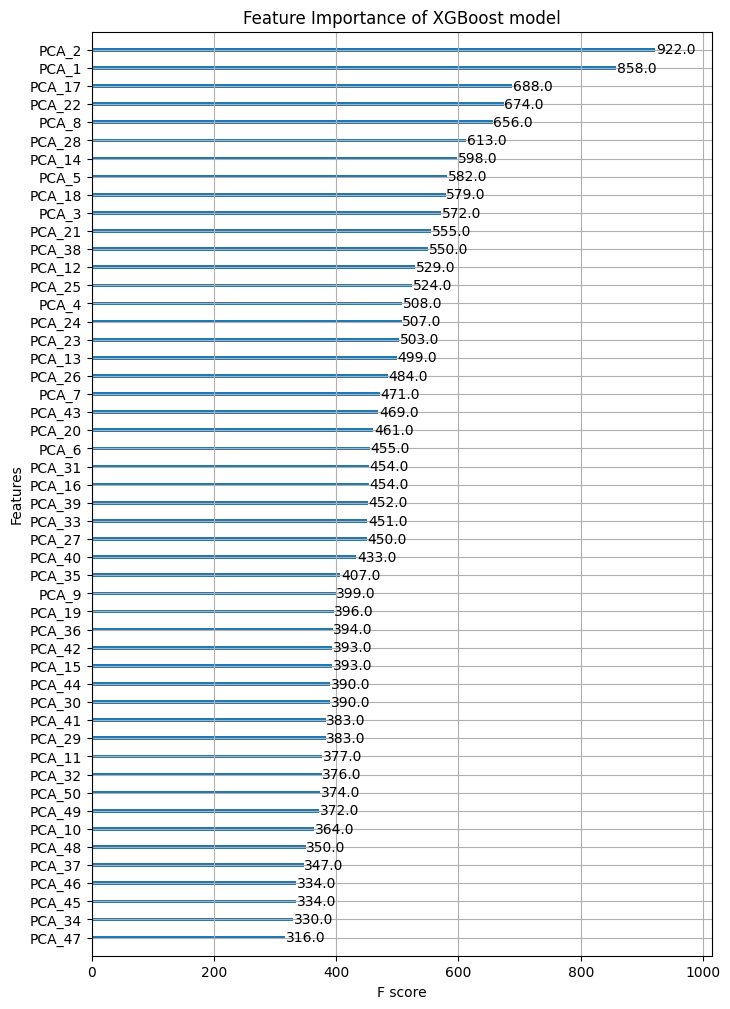

In [82]:
fig, ax = plt.subplots(figsize=(8,12))
from xgboost import plot_importance
plot_importance(xgb, ax=ax, title='Feature Importance of XGBoost model')
plt.show()

PCA2, PCA1이 큰 점수를 가진다.

In [87]:
imp_pc = [2,1,17,22,8]
unimp_pc = [47,34,45,46,37]

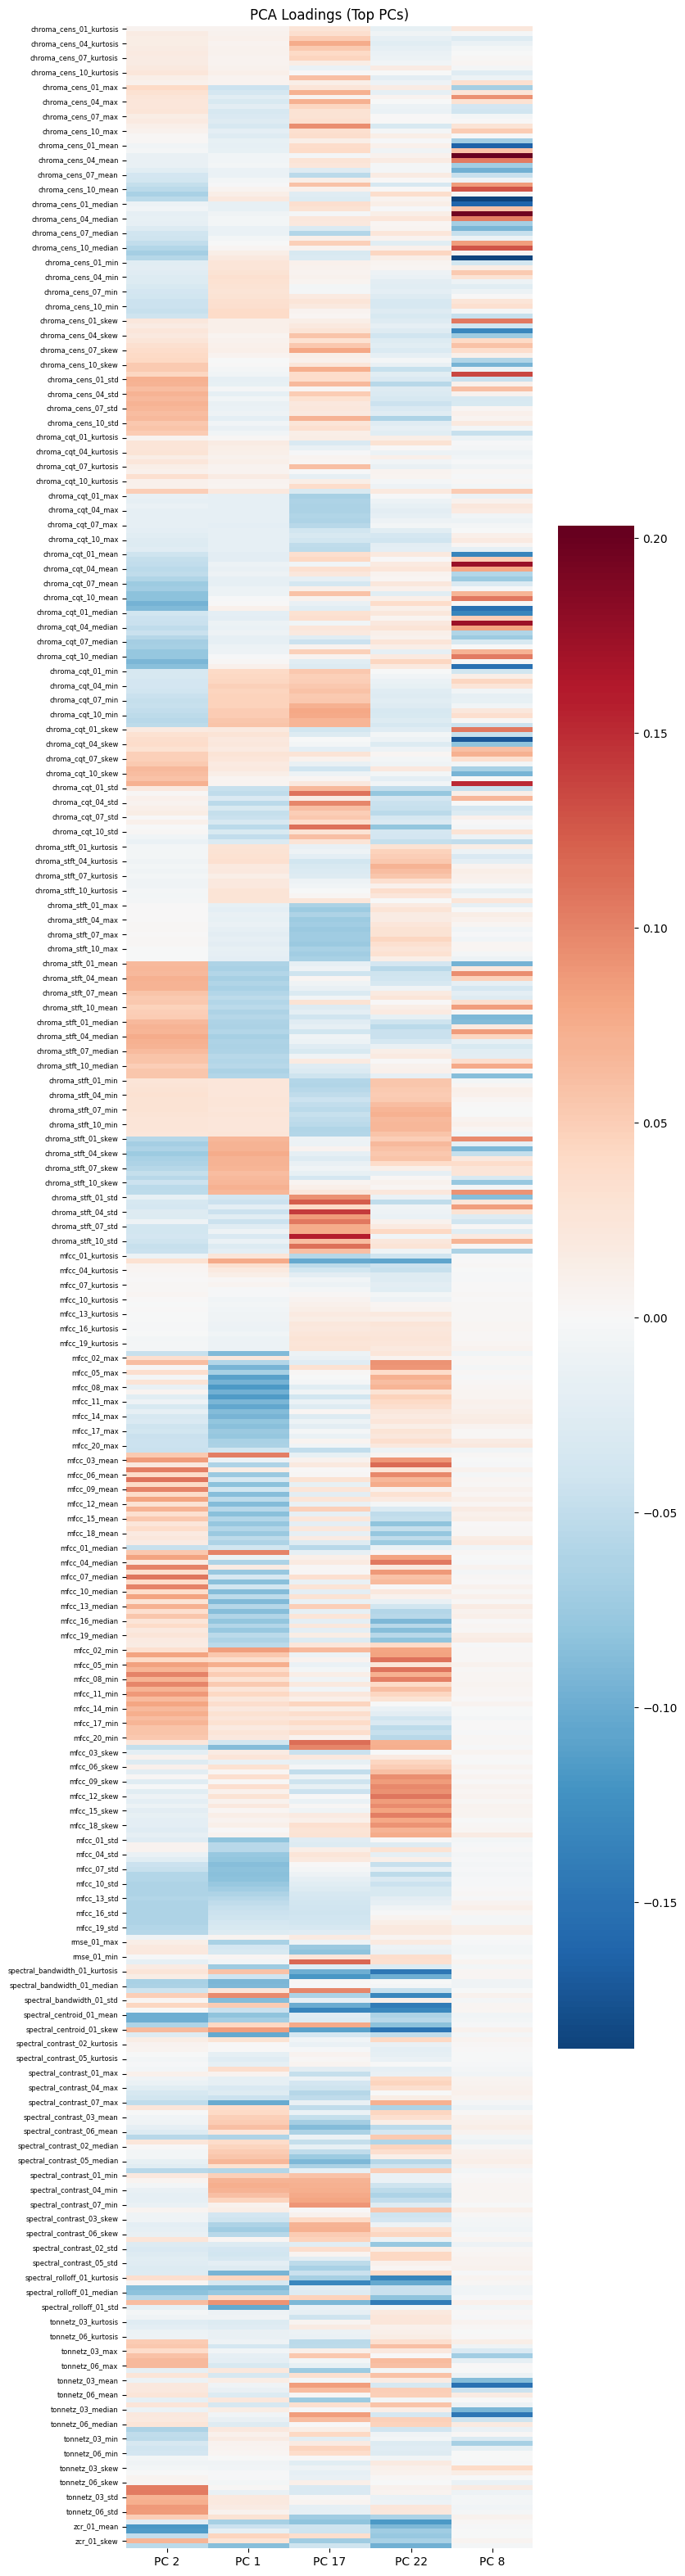

In [104]:
fig, ax = plt.subplots(figsize=(8,40))
sns.heatmap(components[:,imp_pc], cmap="RdBu_r", ax=ax, center=0)
ax.set_yticklabels(labels= raw_X_train.columns[::3], rotation=0, fontdict={'fontsize':6})
ax.set_xticklabels(labels= [f'PC {i}' for i in imp_pc])
ax.set_title("PCA Loadings (Top PCs)")
plt.show()

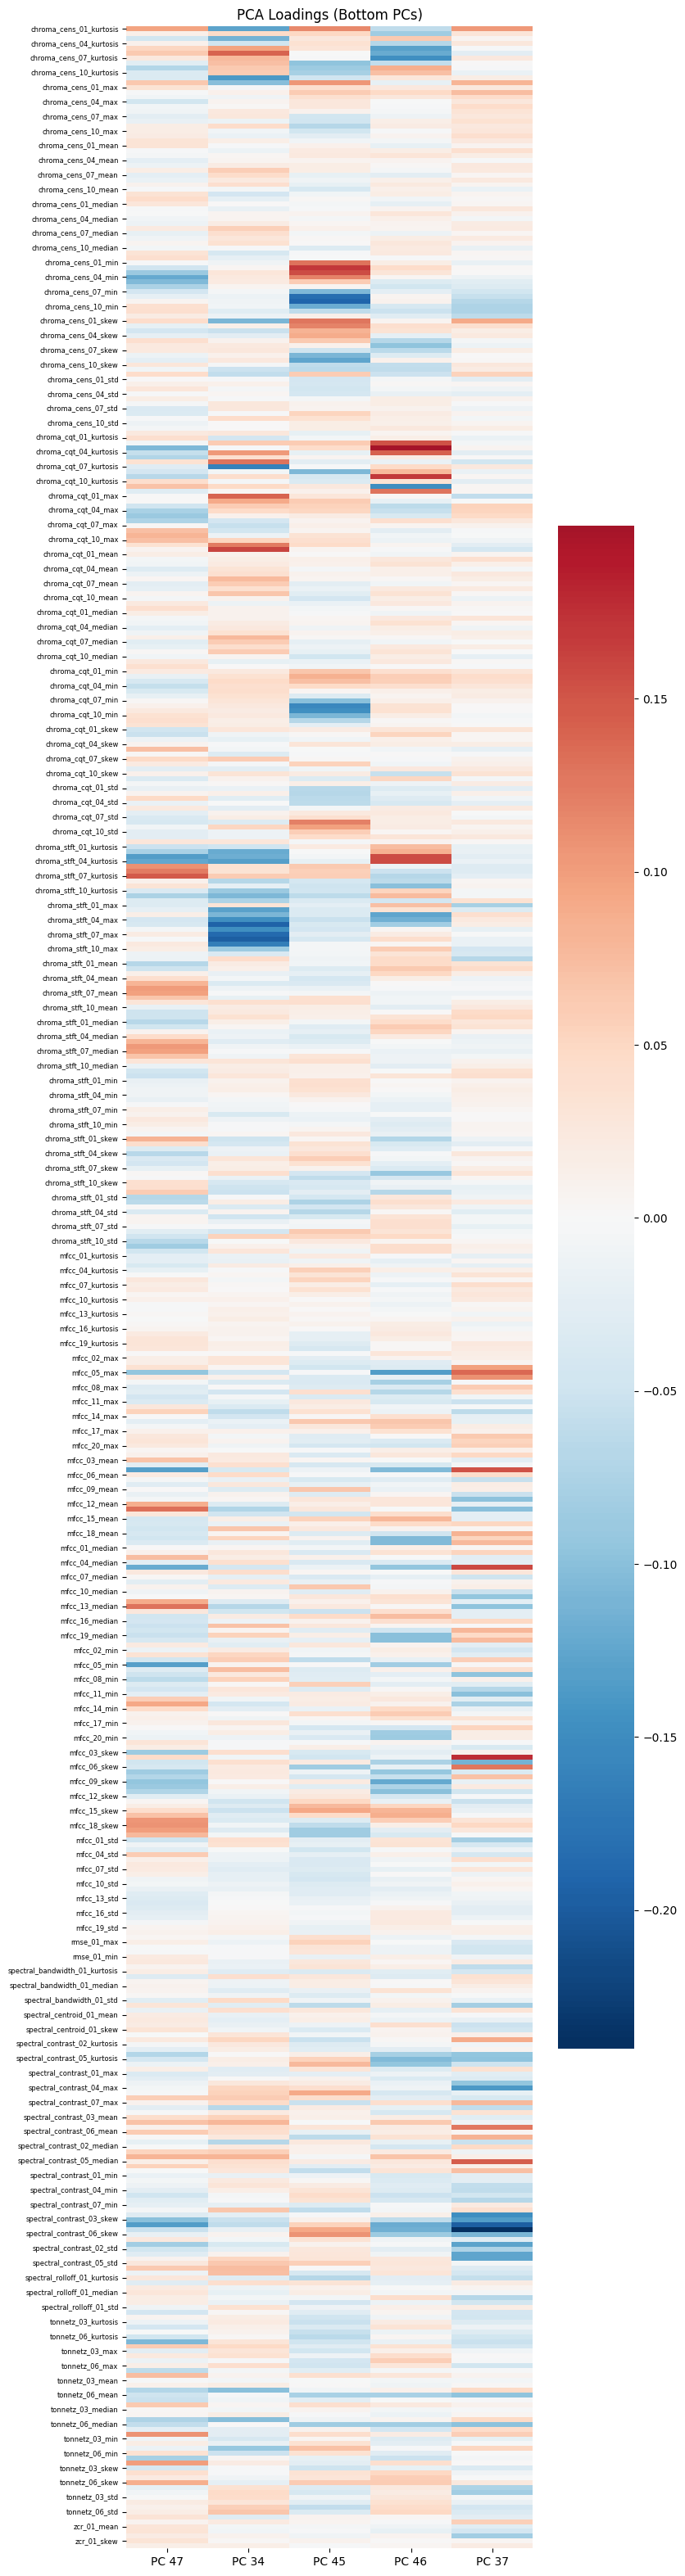

In [105]:
fig, ax = plt.subplots(figsize=(8,40))
sns.heatmap(components[:,unimp_pc], cmap="RdBu_r", ax=ax, center=0)
ax.set_yticklabels(labels= raw_X_train.columns[::3], rotation=0, fontdict={'fontsize':6})
ax.set_xticklabels(labels= [f'PC {i}' for i in unimp_pc])
ax.set_title("PCA Loadings (Bottom PCs)")
plt.show()